In [1]:
%matplotlib inline
from __future__ import print_function, division

import nsfg
import nsfg2
import first

import thinkstats2
import thinkplot

import copy
import random
import numpy as np
import matplotlib.pyplot as pyplot

In [ ]:
class CoinTest(thinkstats2.HypothesisTest):
    """Tests the hypothesis that a coin is fair."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

In [ ]:
ct = CoinTest((140, 110))
pvalue = ct.PValue(10000)
pvalue

In [2]:
class DiffMeansPermute(thinkstats2.HypothesisTest):
    """Tests a difference in means by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [13]:
live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

In [ ]:
ht = DiffMeansPermute(data)
ht.PValue()

In [ ]:
ht.PlotCdf()
thinkplot.Show(xlabel='Test Statistic', ylabel='CDF')

In [ ]:
class DiffMeansOneSided(DiffMeansPermute):
    
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

In [ ]:
ost = DiffMeansOneSided(data)
ost.PValue()

In [ ]:
class DiffStdPermute(DiffMeansPermute):
    
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

In [ ]:
st = DiffStdPermute(data)
st.PValue()

In [ ]:
class CorrelationPermute(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat
    
    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [4]:
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data = live.agepreg.values, live.totalwgt_lb.values

In [ ]:
ht = CorrelationPermute(data)
ht.PValue()

In [ ]:
class CorrelationPermute(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6)*n / 6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat
    
    def RunModel(self):
        n = sum(self.data)
        values = xrange(1, 7)
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

In [ ]:
data = [8, 9, 20, 4, 8, 11]
cp = CorrelationPermute(data)
cp.PValue()

In [ ]:
class PregLengthTest(thinkstats2.HypothesisTest):
    """Tests a difference in means by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        firsts, others = data
        test_stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return test_stat

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))
        
        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

    def ChiSquared(self, lengths):
        """Computes the chi-squared statistic.
        
        lengths: sequence of lengths

        returns: float
        """
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

In [ ]:
plt = PregLengthTest(data)
plt.PValue(10000)

In [5]:
def FalseNegRate(data, num_runs=1000):
    """Computes the chance of a false negative based on resampling.

    data: pair of sequences
    num_runs: how many experiments to simulate

    returns: float false negative rate
    """
    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)
        ht = DiffMeansPermute((sample1, sample2))
        p_value = ht.PValue(iters=101)
        if p_value > 0.05:
            count += 1

    return count / num_runs

In [14]:
def PowerTest(data, sample_size=100):
    
    firsts, others = data
    
    firsts = thinkstats2.SampleRows(firsts, sample_size)
    others = thinkstats2.SampleRows(others, sample_size)
    group1, group2 = firsts.prglngth.values, others.prglngth.values
    neg_rate = FalseNegRate((group1, group2))
    return neg_rate

0.551

100 : 0.909
200 : 0.816
300 : 0.675
400 : 0.838
500 : 0.902
600 : 0.637
700 : 0.858
800 : 0.93
900 : 0.744
1000 : 0.646


ValueError: x and y must have same first dimension

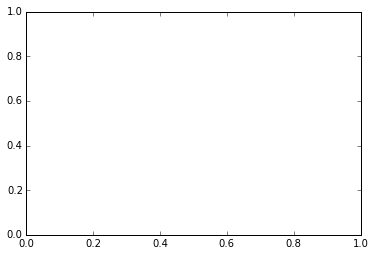

In [15]:
neg_rates = []
data = firsts, others
for i in xrange(100, 1001, 100):
    nr = PowerTest(data, i)
    neg_rates.append(nr)
    print(i, ':', nr)
thinkplot.Plot(xrange(100, 5001, 100), neg_rates)

In [ ]:
class DiffMeansResample(DiffMeansPermute):
    
    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        pool = thinkstats2.Resample(self.pool)
        data = pool[:self.n], pool[self.n:]
        return data